In [1]:
!pip install pmdarima

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from math import sqrt
from sklearn.metrics import r2_score , mean_absolute_error , mean_absolute_percentage_error , mean_squared_error
import pickle
import warnings
warnings.filterwarnings('ignore')

   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   -- ------------------------------------ 41.0/625.1 kB 991.0 kB/s eta 0:00:01
   ----- ---------------------------------- 92.2/625.1 kB 1.3 MB/s eta 0:00:01
   ------- ------------------------------ 122.9/625.1 kB 901.1 kB/s eta 0:00:01
   --------- ------------------------------ 153.6/625.1 kB 1.0 MB/s eta 0:00:01
   ------------ ------------------------- 204.8/625.1 kB 958.4 kB/s eta 0:00:01
   ---------------- ----------------------- 256.0/625.1 kB 1.1 MB/s eta 0:00:01
   ---------------- ----------------------- 256.0/625.1 kB 1.1 MB/s eta 0:00:01
   ------------------ ------------------- 297.0/625.1 kB 874.1 kB/s eta 0:00:01
   --------------------- ---------------- 348.2/625.1 kB 941.3 kB/s eta 0:00:01
   ------------------------ ------------- 399.4/625.1 kB 958.4 kB/s eta 0:00:01
   -------------------------- ----------- 430.1/625.1 kB 960.7 kB/s eta 0:00:01
   ---------------------------- --------- 460.8/62


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
data = pd.read_csv('exchange_rate.csv')
data

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [3]:
data.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [5]:
data.dtypes

date        object
Ex_rate    float64
dtype: object

In [6]:
data['date'] = pd.to_datetime(data['date'],format = 'mixed')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     7588 non-null   datetime64[ns]
 1   Ex_rate  7588 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 118.7 KB


In [8]:
data = data.set_index('date')

In [9]:
data.head(2)

,Ex_rate
date,
1990-01-01,0.7855
1990-02-01,0.7818


In [10]:
data.isnull().sum()

Ex_rate    0
dtype: int64

### Data Visualization.

<Axes: ylabel='Ex_rate'>

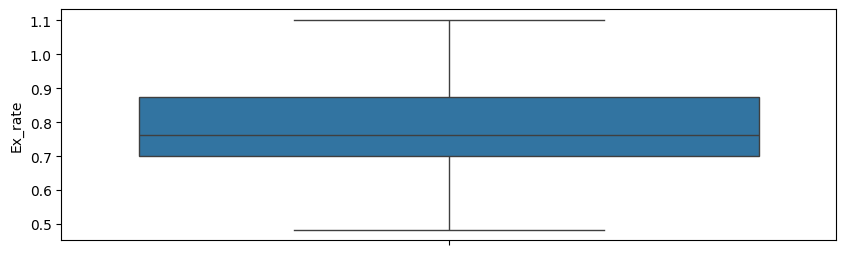

In [11]:
plt.figure(figsize=(10,3))
sns.boxplot(data=data['Ex_rate'])

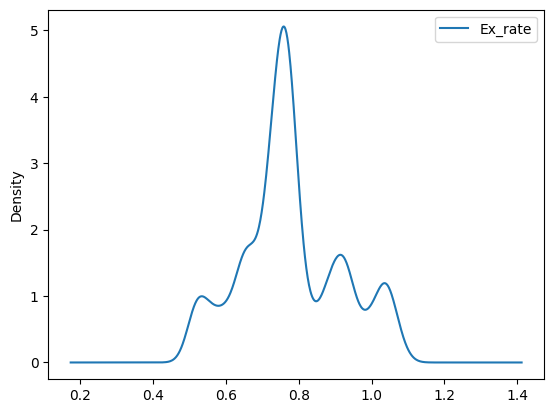

In [12]:
data.plot(kind='kde')
plt.show()

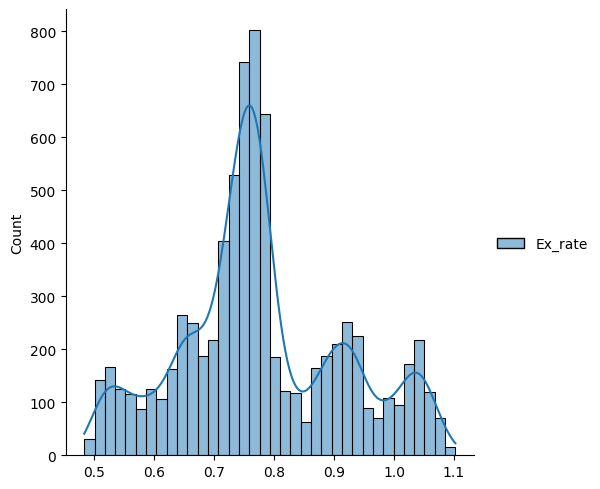

In [13]:
sns.displot(data, kde=True)

array([[<Axes: title={'center': 'Ex_rate'}>]], dtype=object)

<Figure size 2000x1000 with 0 Axes>

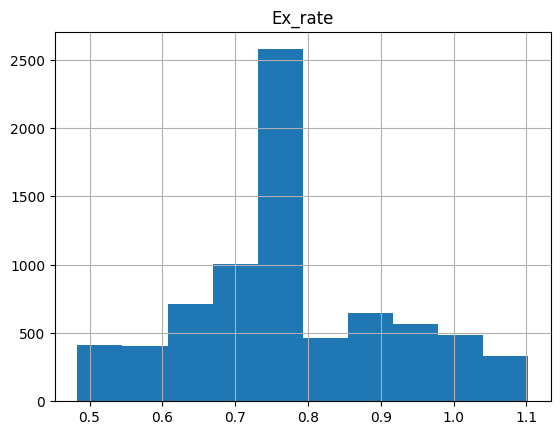

In [14]:
plt.figure(figsize=(20,10))
data.hist()

<Axes: xlabel='date', ylabel='Ex_rate'>

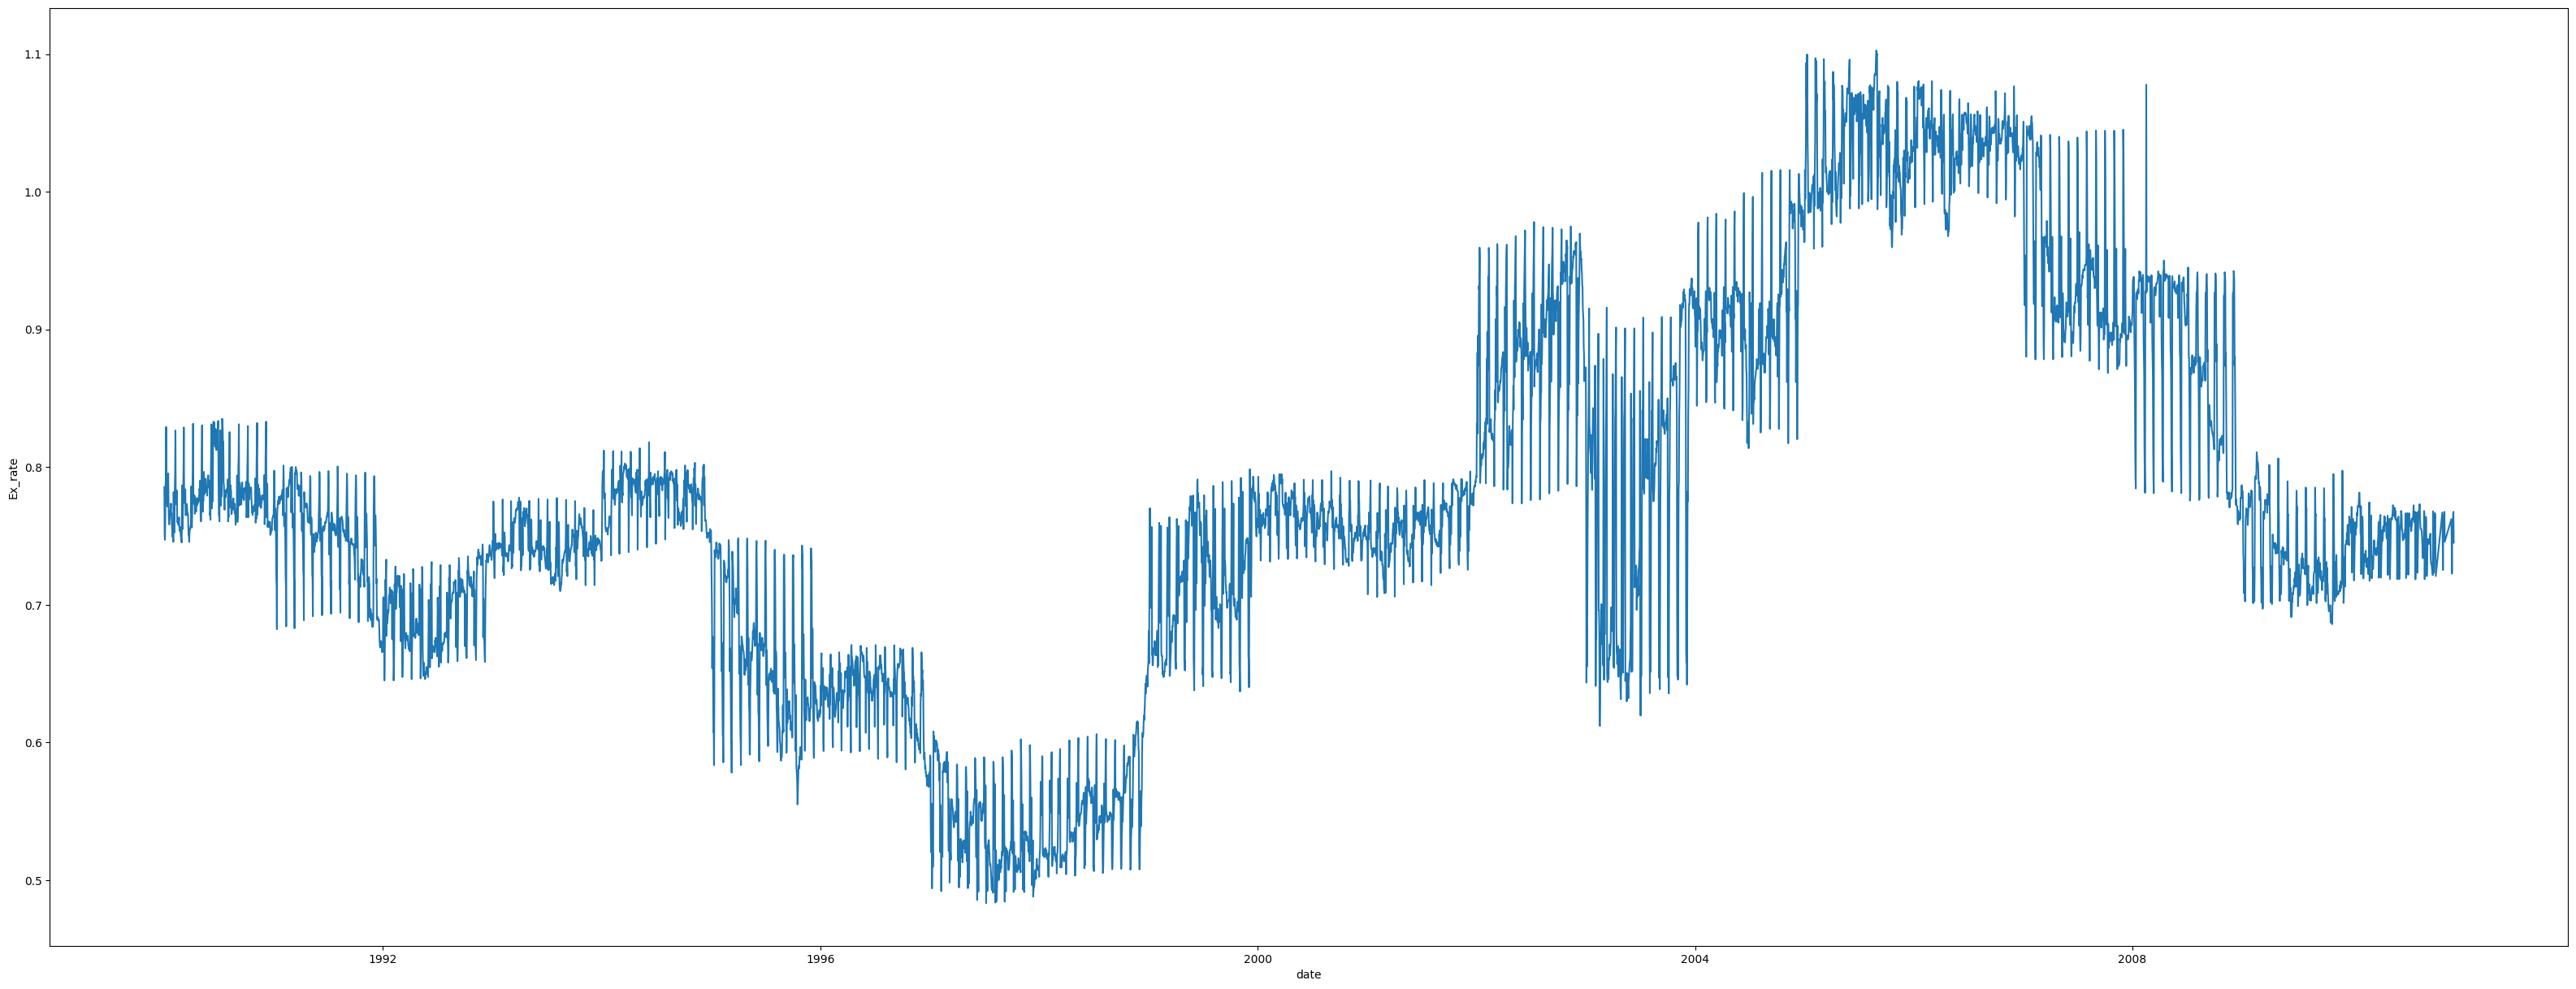

In [15]:
plt.figure(figsize=(40,15))
sns.lineplot(x="date",y="Ex_rate",data=data)

<Axes: xlabel='date', ylabel='Ex_rate'>

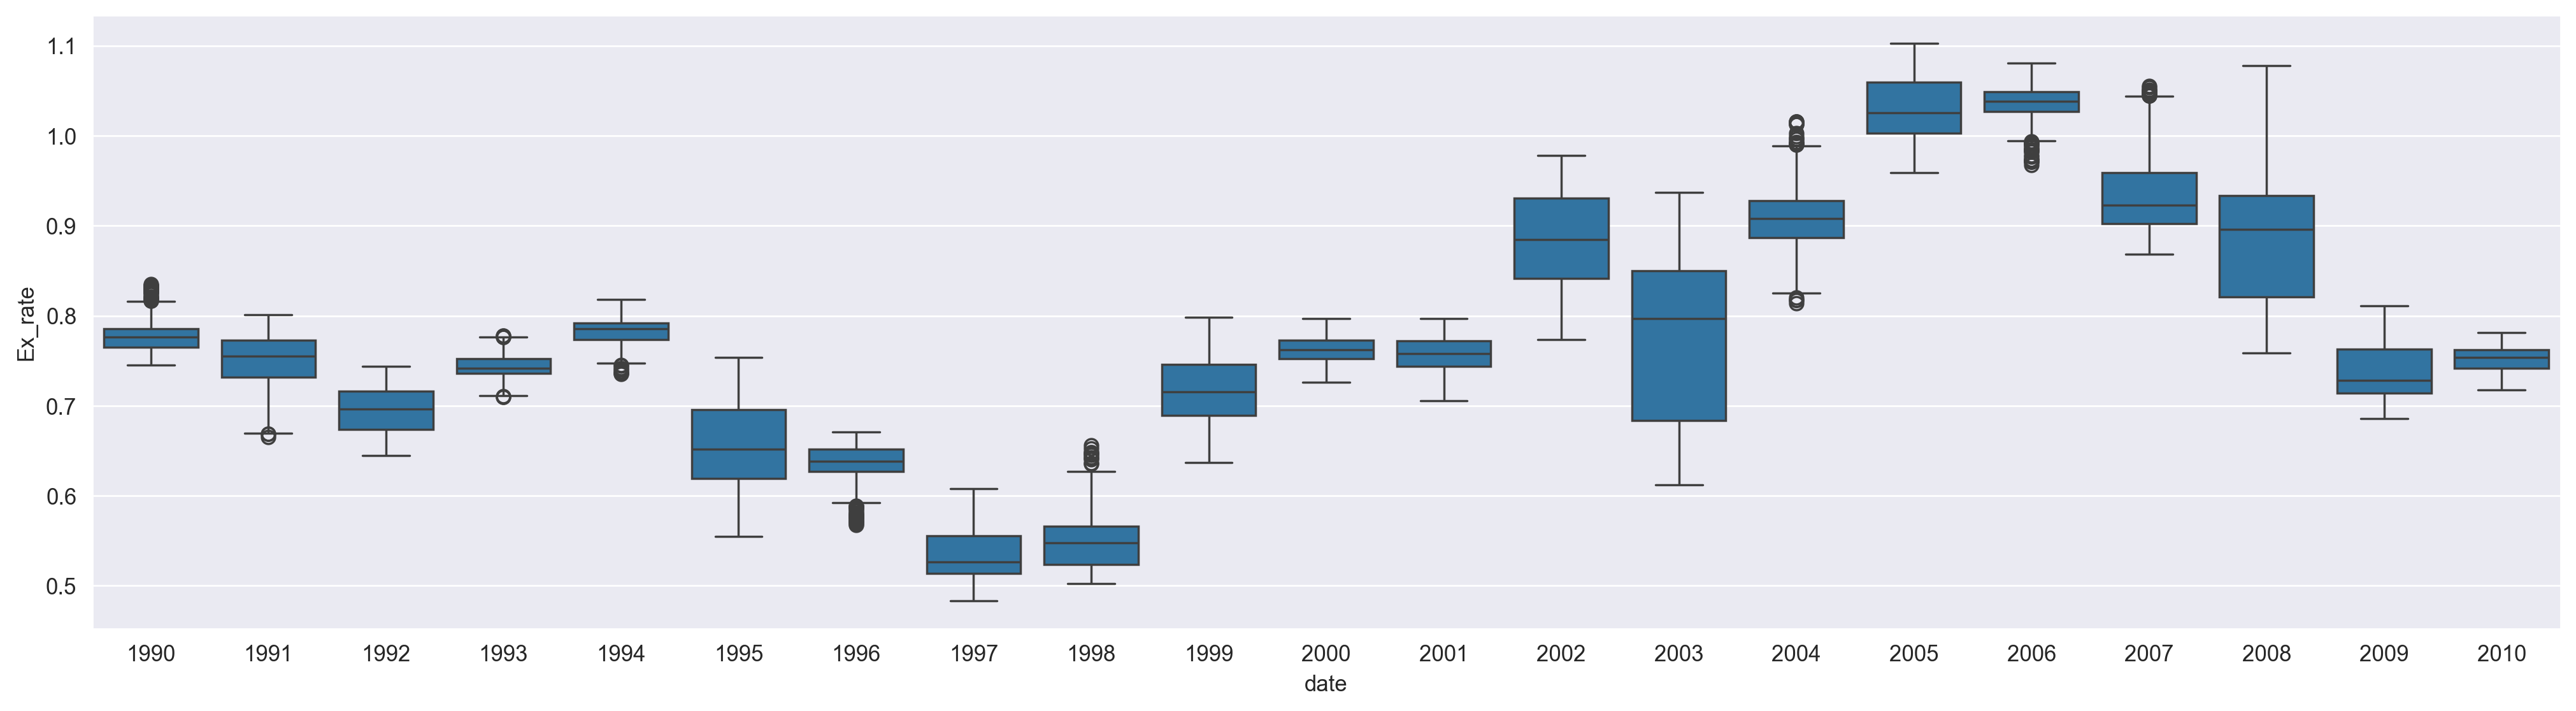

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
fig,ax = plt.subplots(figsize=(20,5))
sns.boxplot(x = data.index.year, 
                y = data.Ex_rate, 
                ax = ax)

<Axes: xlabel='date', ylabel='Ex_rate'>

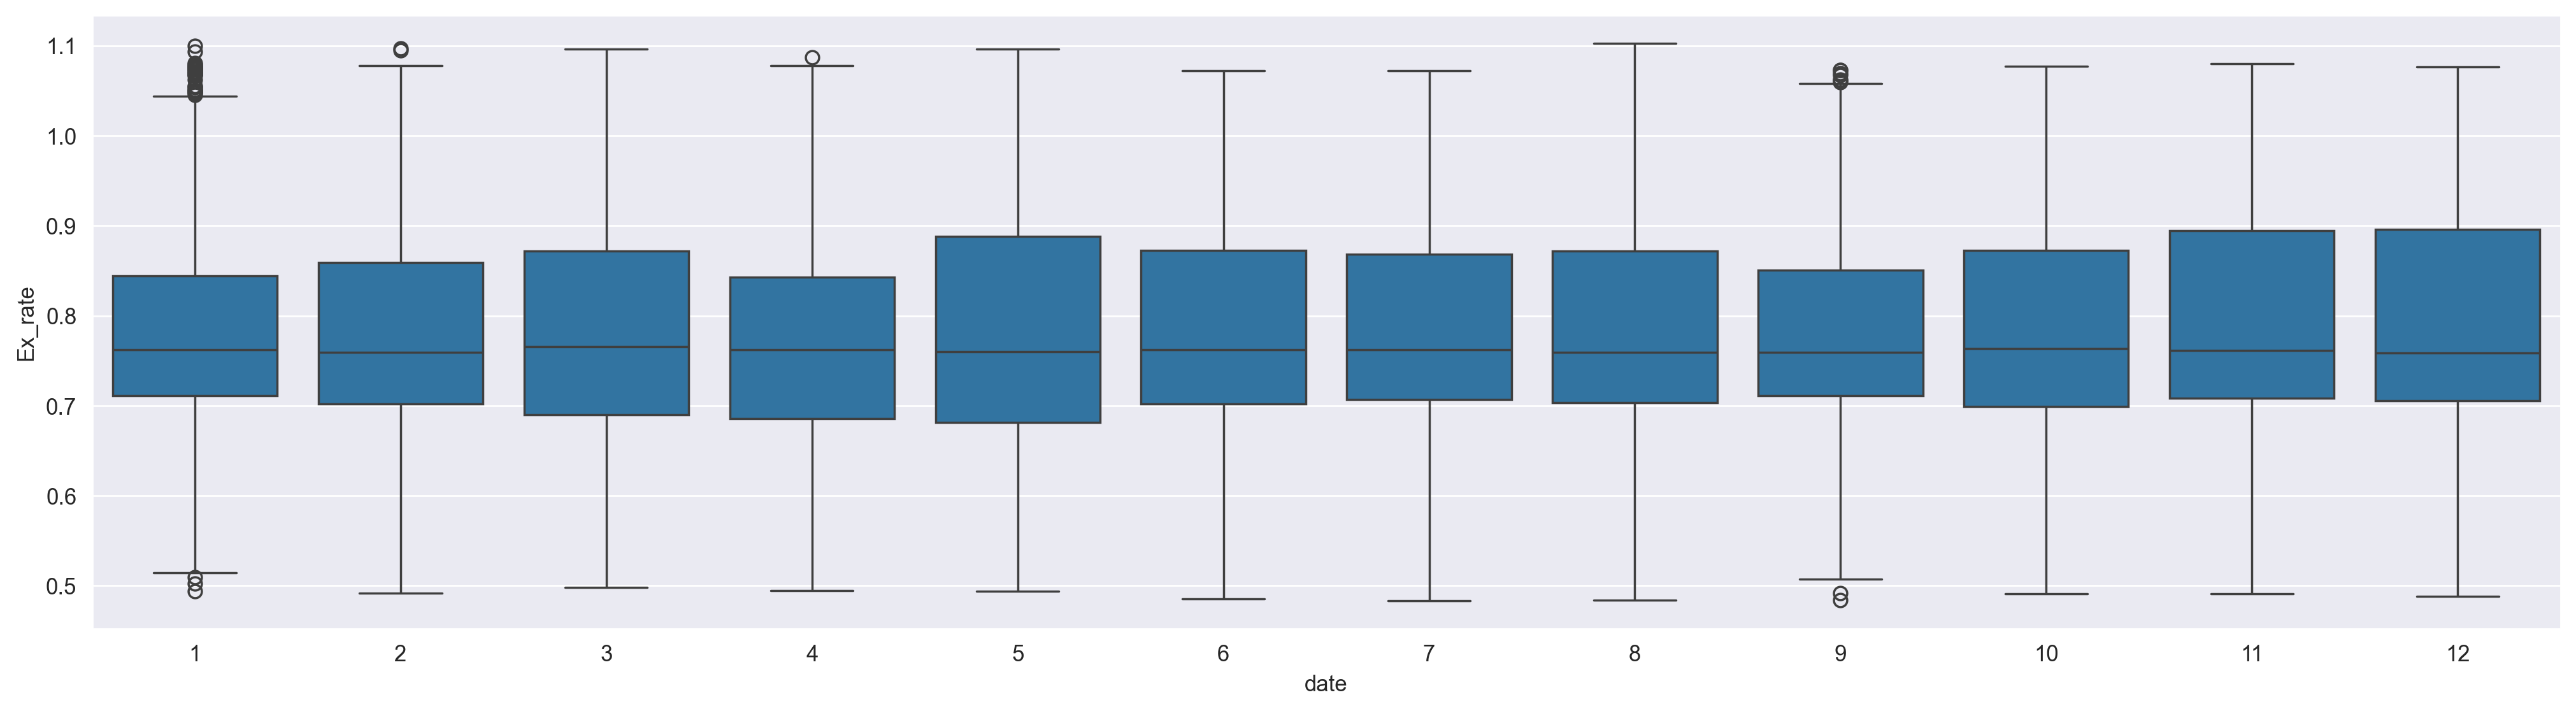

In [18]:
fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(x = data.index.month, 
                y = data.Ex_rate, 
                ax = ax)

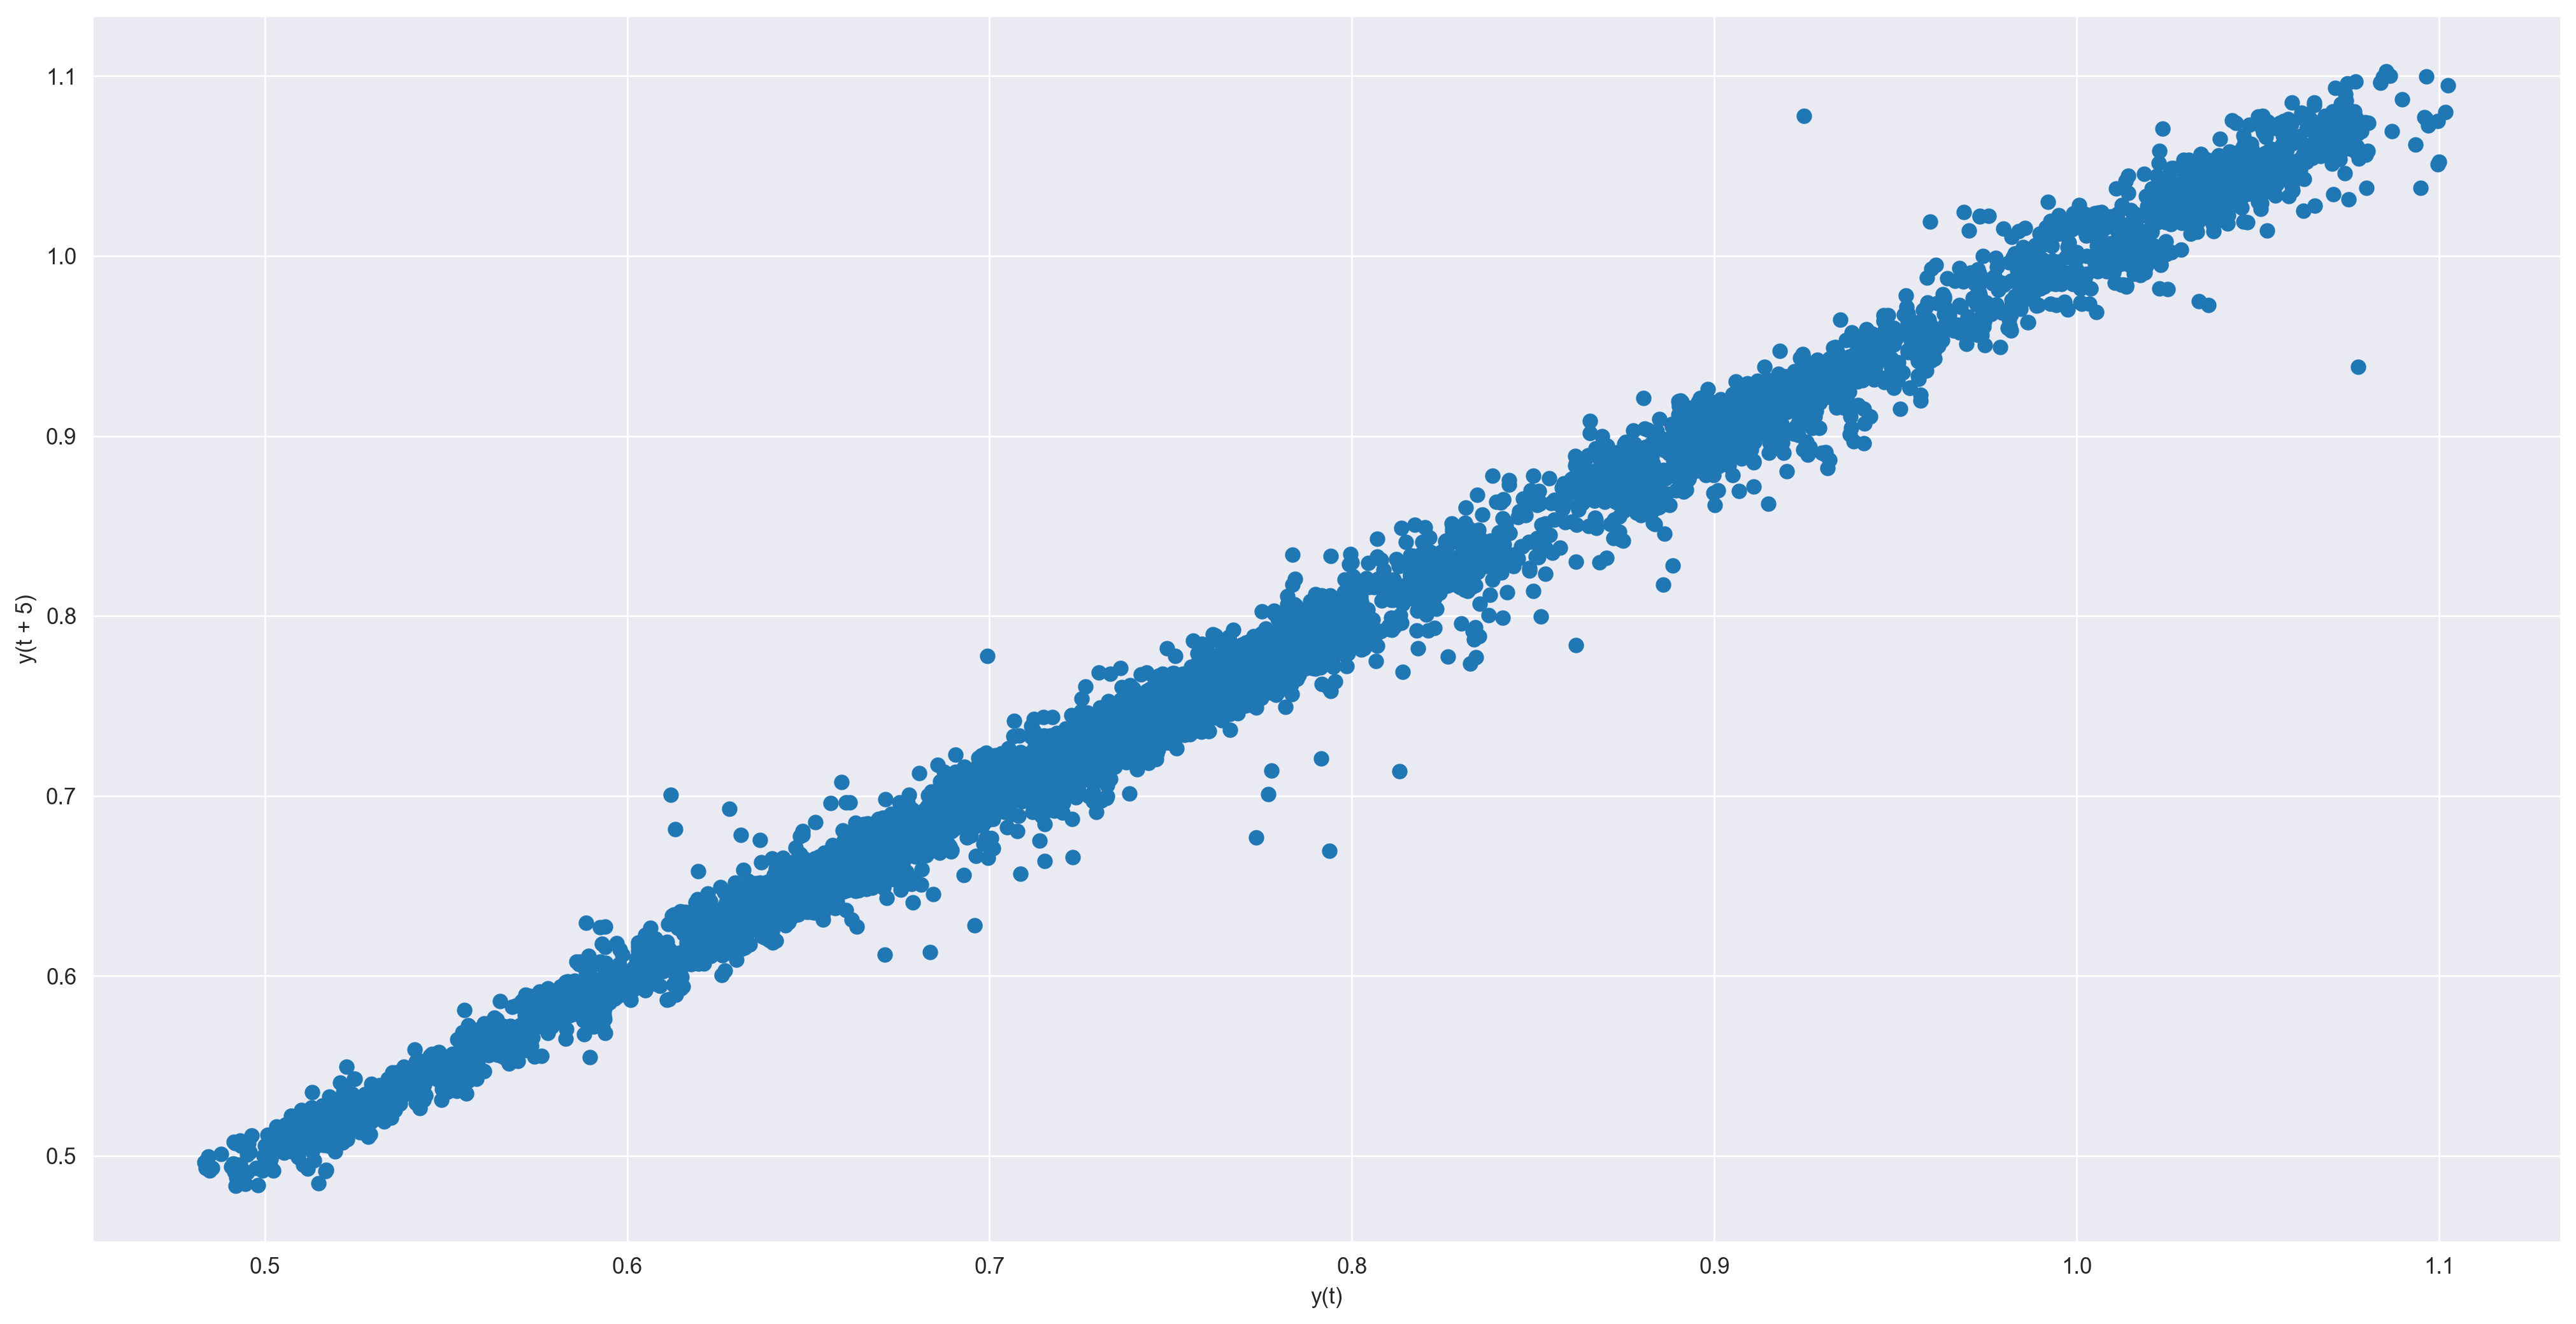

In [25]:
from pandas.plotting import lag_plot
plt.figure(figsize=(20,10))
lag_plot(data, lag=5)
plt.show()

##### Resampling the dataset to weekly frequency since the given data has more number of observations that takes longer time to fit or predict the model. And along with that showing number of observation after resampling and displaying the first five record of resampled dataset

In [17]:
data_week = data.resample('W').mean()
print('Count of The Weekly Data Frame : ',data_week.shape[0])
data_week.head()

Count of The Weekly Data Frame :  1093


,Ex_rate
date,
1990-01-07,0.778300
1990-01-14,0.781486
1990-01-21,0.764871
1990-01-28,0.762429
1990-02-04,0.757243


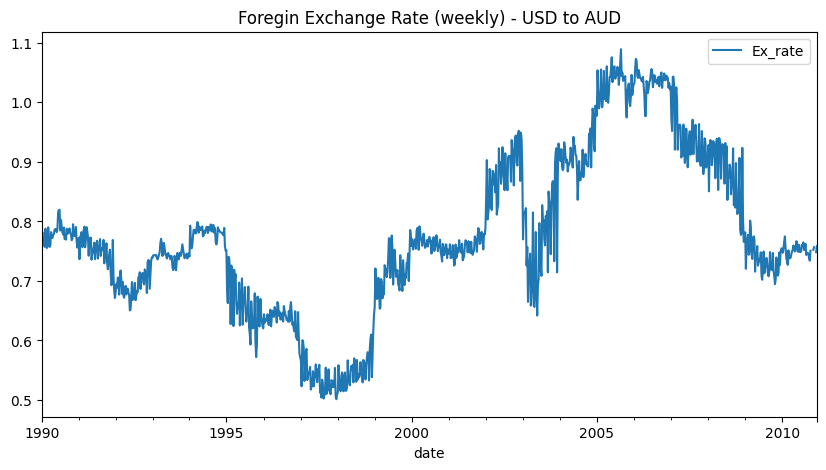

In [18]:
#Plotting the line graph to show the data trend in the weekly resampled dataset 
data_week.plot(figsize = (10,5))
plt.title('Foregin Exchange Rate (weekly) - USD to AUD')
plt.show()

### Resampling the dataset to monthly frequency since the given data has more number of observations that takes longer time to fit or predict the model. And along with that showing number of observation after resampling and displaying the first five record of resampled dataset

In [20]:
data_month = data.resample('M').mean()
print('Count of The Monthly Data Frame : ',data_month.shape[0])
data_month.head()

Count of The Monthly Data Frame :  252


,Ex_rate
date,
1990-01-31,0.769661
1990-02-28,0.765589
1990-03-31,0.768568
1990-04-30,0.777073
1990-05-31,0.784868


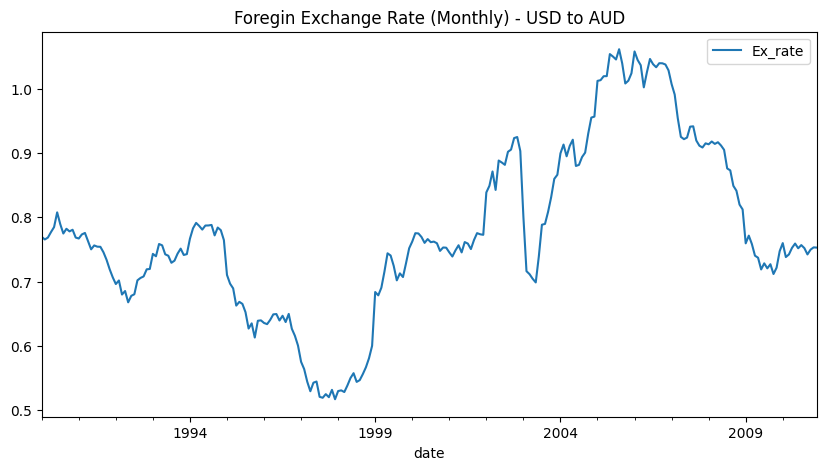

In [21]:
#Plotting the line graph to show the data trend in the monthly resampled dataset
data_month.plot(figsize = (10,5))
plt.title('Foregin Exchange Rate (Monthly) - USD to AUD')
plt.show()

### Resampling the dataset to yearly frequency since the given data has more number of observations that takes longer time to fit or predict the model. And along with that showing number of observation after resampling and displaying the first five record of resampled dataset

In [22]:
data_year = data.resample('Y').mean()
print('Count of The Yearly Data Frame : ',data_year.shape[0])
data_year.head()

Count of The Yearly Data Frame :  21


,Ex_rate
date,
1990-12-31,0.778996
1991-12-31,0.749830
1992-12-31,0.695201
1993-12-31,0.743442
1994-12-31,0.781024


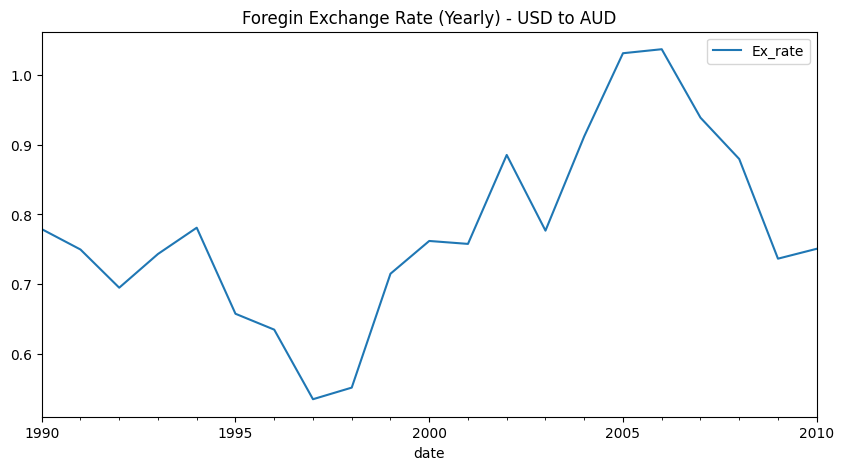

In [23]:
data_year.plot(figsize = (10,5))
plt.title('Foregin Exchange Rate (Yearly) - USD to AUD')
plt.show()

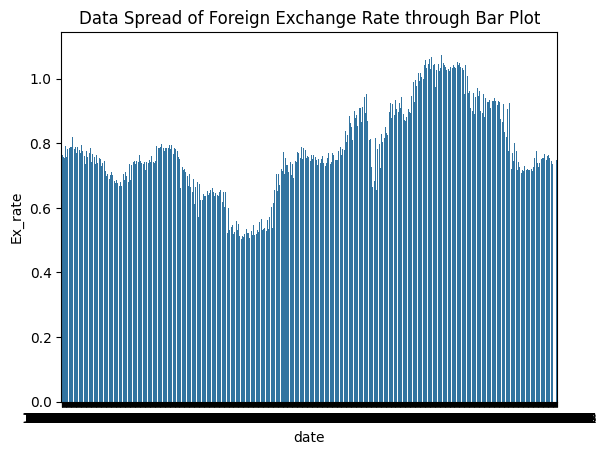

In [24]:
sns.barplot(data = data_week,x = data_week.index , y = data_week.Ex_rate)
plt.title('Data Spread of Foreign Exchange Rate through Bar Plot')
plt.show()

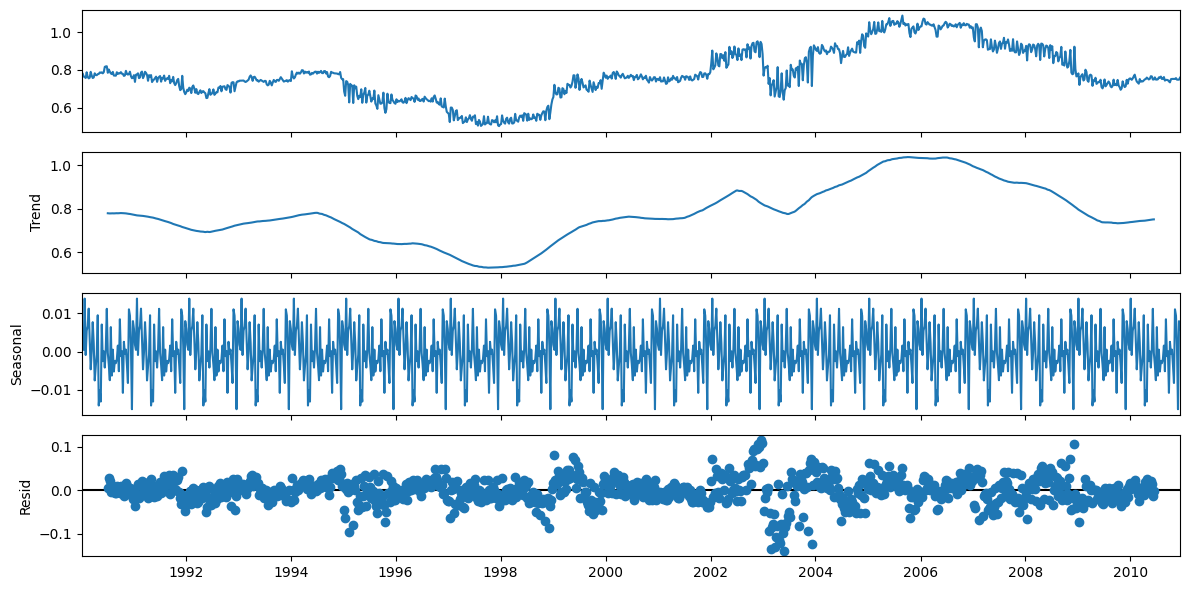

In [25]:
plt.rcParams['figure.figsize']=(12,6)
decomposition = seasonal_decompose(data_week.fillna(method='bfill'), period = 52 , model = 'additive')
decomposition.plot()
plt.savefig('Discription , trend , seasonal , residuals.png')
plt.show()

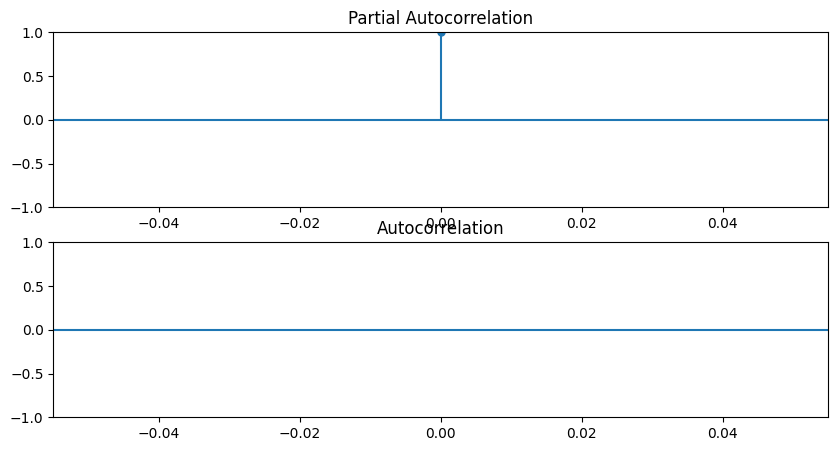

<Figure size 1200x600 with 0 Axes>

In [27]:
#Plotting the graph with Partial Autocorrelation and Auto Correleation of the data from the dataset and saving the graph as PNG file
fig , (ax1,ax2) = plt.subplots(nrows = 2 ,ncols = 1,sharex = False , sharey = False , figsize = (10,5))
ax1 = plot_pacf(data_week , lags = 5 , ax = ax1)
ax2 = plot_acf(data_week , lags = 5 , ax = ax2)
plt.show()
plt.tight_layout()

## Data Transformation
The adf_check() function performs an Augmented Dickey-Fuller test on a time series. The test is used to determine whether a time series is stationary or not. If the p-value of the test is less than or equal to 0.05, then there is strong evidence against the null hypothesis, and the series is considered to be stationary. Otherwise, the series is considered to be non-stationary. The function takes a time series as input and returns the results of the test. The results are printed to the console, along with a message indicating whether the series is stationary or not.


In [28]:
def adf_check(time_series):
    result = adfuller(time_series , autolag = 'AIC')
    label = pd.Series(result[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in result[4].items():
        label['Critical Value (%s)'%key] = value
    print(label)
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis, hence REJECT null hypothesis and the series is Stationary')
    else:
        print ('Weak evidence against the null hypothesis, hence ACCEPT null hypothesis and the series is Not Stationary ')

In [30]:
# Check for missing values
missing_values = data_week.isnull().sum()
print(missing_values)

Ex_rate    5
dtype: int64


In [31]:
# Check for infinite values
infinite_values = np.isinf(data_week).sum()
print(infinite_values)

Ex_rate    0
dtype: int64


In [32]:
# Remove rows with missing values
data_week = data_week.dropna()

In [33]:
# Check for missing values
missing_values = data_week.isnull().sum()
print(missing_values)

Ex_rate    0
dtype: int64


In [34]:
adf_check(data_week)

Test Statistic                   -1.808866
p-value                           0.376069
Number of Lags Used              22.000000
Number of Observations Used    1065.000000
Critical Value (1%)              -3.436505
Critical Value (5%)              -2.864258
Critical Value (10%)             -2.568217
dtype: float64
Weak evidence against the null hypothesis, hence ACCEPT null hypothesis and the series is Not Stationary 


#### Since the time series is not a stationary , the resampled weekly dataset is transformed as a new dataframe with first difference to make it as a stationary series. Along with that showing number of observation in the new dataframe and displaying the first five record of the new data frame



In [35]:
data_week1 = data_week.diff().dropna()
print('Count of weekly First Difference',data_week1.shape[0])
data_week1.head()

Count of weekly First Difference 1087


,Ex_rate
date,
1990-01-14,0.003186
1990-01-21,-0.016614
1990-01-28,-0.002443
1990-02-04,-0.005186
1990-02-11,0.030600


In [36]:
#Performing the Augmented Dickey Fuller Test on the new transformed data in the resampled weekly dataset to find whether the time series is a stationary or not
adf_check(data_week1)

Test Statistic                -5.898755e+00
p-value                        2.810497e-07
Number of Lags Used            2.100000e+01
Number of Observations Used    1.065000e+03
Critical Value (1%)           -3.436505e+00
Critical Value (5%)           -2.864258e+00
Critical Value (10%)          -2.568217e+00
dtype: float64
Strong evidence against the null hypothesis, hence REJECT null hypothesis and the series is Stationary


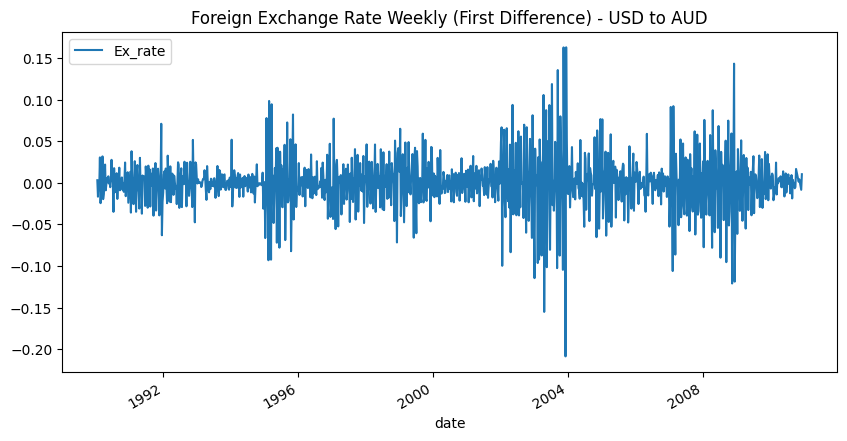

In [37]:
#Plotting the line graph to show the data trend in the transformed data from the resampled weekly dataset and saving the graph as PNG File
data_week1.plot(figsize = (10,5))
plt.title('Foreign Exchange Rate Weekly (First Difference) - USD to AUD')
plt.show()

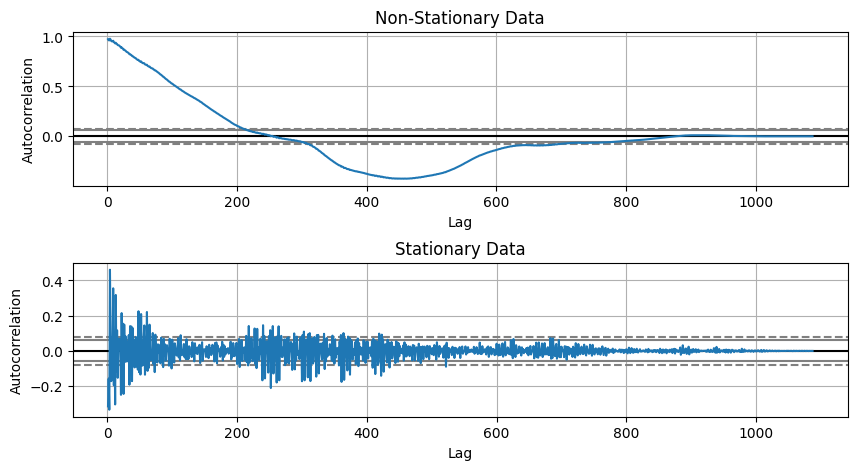

In [38]:
fig , (ax1,ax2) = plt.subplots(nrows = 2 ,ncols = 1,sharex = False , sharey = False , figsize = (10,5))
ax1 = autocorrelation_plot(data_week , ax = ax1)
ax1.set_title('Non-Stationary Data')
ax2 = autocorrelation_plot(data_week1 , ax = ax2)
ax2.set_title('Stationary Data')
plt.subplots_adjust(hspace = 0.5)
plt.savefig('Stationary data and Non-Stationary data.png')
plt.show()

# Model Fitting

In [39]:
#Getting the p value and q value for the model fitting using auto_arima function by passing through some needed parameters , the best model is evaluated by least Akaike Information Criterion (AIC)
model = auto_arima(data_week , m = 52, d = 1 ,seasonal = False , max_order = 8 , test = 'adf' , trace = True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4938.189, Time=3.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4433.972, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4545.126, Time=0.87 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4749.536, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4435.972, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4759.870, Time=2.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4811.293, Time=1.58 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-5108.737, Time=2.90 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5090.030, Time=2.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-5089.238, Time=3.39 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-5108.038, Time=2.90 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-4891.528, Time=3.73 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-5093.238, Time=2.77 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-5105.923, Time=4.13 sec
 ARIMA(3,1,2)(0,0,0

##### Defining the summary of the model fitted with auto_arima function , here getting various information such as Akaike Information Criterion (AIC), Bayesian Information Criterion (BIC) , Hannan-Quinn Information Criterion (HQIC), Log Likelihood etc. From which we can evaluate the model

In [40]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1088
Model:               SARIMAX(5, 1, 2)   Log Likelihood                2601.005
Date:                Thu, 18 Jul 2024   AIC                          -5186.011
Time:                        22:08:35   BIC                          -5146.081
Sample:                             0   HQIC                         -5170.896
                               - 1088                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5282      0.038    -13.835      0.000      -0.603      -0.453
ar.L2          0.3270      0.054      6.051      0.000       0.221       0.433
ar.L3         -0.1236      0.032     -3.812      0.000      -0.187      -0.060
ar.L4          0.4083      0.033     12.201      0.000       0.343       0.474
ar.L5          0.6330      0.024     25.899      0.000       0.585       0.681
ma.L1          0.0012      0.037      0.032      0.975      -0.072       0.074
ma.L2         -0.8290      0.038    -21.830      0.000      -0.903      -0.755
sigma2         0.0005   1.37e-05     36.920      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):               836.27
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
model = ARIMA(data_week , order = (5,1,2))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Ex_rate   No. Observations:                 1088
Model:                 ARIMA(5, 1, 2)   Log Likelihood                2601.005
Date:                Thu, 18 Jul 2024   AIC                          -5186.011
Time:                        22:08:43   BIC                          -5146.081
Sample:                             0   HQIC                         -5170.896
                               - 1088                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5282      0.038    -13.835      0.000      -0.603      -0.453
ar.L2          0.3270      0.054      6.051      0.000       0.221       0.433
ar.L3         -0.1236      0.032     -3.812      0.000      -0.187      -0.060
ar.L4          0.4083      0.033     12.201      0.000       0.343       0.474
ar.L5          0.6330      0.024     25.899      0.000       0.585       0.681
ma.L1          0.0012      0.037      0.032      0.975      -0.072       0.074
ma.L2         -0.8290      0.038    -21.830      0.000      -0.903      -0.755
sigma2         0.0005   1.37e-05     36.920      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):               836.27
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

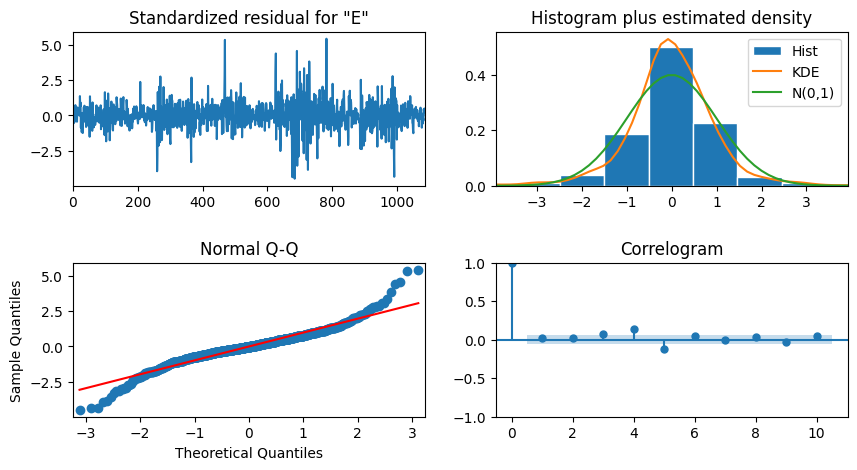

In [42]:
##Plotting the diagnostic plot for the fitted model to show the best fit of the model.
result.plot_diagnostics(figsize = (10,5))
plt.subplots_adjust(hspace = 0.5)
plt.savefig('Diagnostic plot of best model.png')
plt.show()


In [43]:
#Predicting the value using fitted model with whole resampled weekly data
predictions = result.predict(typ = 'levels')


# Model Evaluation

Evaluating the model with the following metrics such as percentage of r2 score , mean squared error , root mean squared error , mean absolute error and mean absolute percentage error for the predicted value and whole data value.

In [44]:
print('Evaluation Result for whole data : ','\n')
print('R2 Score for whole data : {0:.2f} %'.format(100*r2_score(data_week['Ex_rate'],predictions)),'\n')
print('Mean Squared Error : ',mean_squared_error(data_week['Ex_rate'],predictions),'\n')
print('Mean Absolute Error : ',mean_absolute_error(data_week['Ex_rate'],predictions),'\n')
print('Root Mean Squared Error : ',sqrt(mean_squared_error(data_week['Ex_rate'],predictions)),'\n')
print('Mean Absolute Percentage Error : {0:.2f} %'.format(100*mean_absolute_percentage_error(data_week['Ex_rate'],predictions)))

Evaluation Result for whole data :  

R2 Score for whole data : 94.23 % 

Mean Squared Error :  0.0010437931182107254 

Mean Absolute Error :  0.01621642260692978 

Root Mean Squared Error :  0.03230778726887258 

Mean Absolute Percentage Error : 2.12 %


# Final Result

Concating the Resampled weekly dataset and weekly first difference dataframe and the prediction value and naming the columns as Foreign Exchange Rate (weekly)','Weekly First Difference','Predicted Exchange Rate and exporting the dataframe to [Comma Seperated Value (CSV)] file. Also displaying the first five records of the exported dataframe.



In [45]:
Final_data = pd.concat([data_week,data_week1,predictions],axis=1)
Final_data.columns = ['Foreign Exchange Rate (weekly)','Weekly First Difference','Predicted Exchange Rate']
Final_data.to_csv('Foreign Exchange Rate with Prediction (USD to AUD).csv')
Final_data.head()

,Foreign Exchange Rate (weekly),Weekly First Difference,Predicted Exchange Rate
date,,,
1990-01-07,0.778300,NaN,0.000000
1990-01-14,0.781486,0.003186,0.778300
1990-01-21,0.764871,-0.016614,0.780564
1990-01-28,0.762429,-0.002443,0.770143
1990-02-04,0.757243,-0.005186,0.770300


# Model Testing

Splliting the Resampled Weekly Dataset into training data and test data. Displaying the number of observations in both training data and test data.

In [46]:
size = int(len(data_week)*0.80)
train , test = data_week[0:size]['Ex_rate'] , data_week[size:(len(data_week))]['Ex_rate']
print('Counts of Train Data : ',train.shape[0])
print('Counts of Train Data : ',test.shape[0])

Counts of Train Data :  870
Counts of Train Data :  218


In [47]:
#Creating the list of train dataset values in train_values and empty predictions list which will be appended after the prediction. Then fitting the model with ARIMA model with the best value got from auto_arima model in the train_values data and predicting with test data value and appending it to the predictions list and printing the comparison between predicted value and actual value
train_values = [x for x in train]
prediction = []
print('Printing Predictied vs Expected Values....')
print('\n')
for t in range(len(test)):
    model = ARIMA(train_values , order = (0,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    pred_out = output[0]
    prediction.append(float(pred_out))
    test_in = test[t]
    train_values.append(test_in)
    print('Predicted = %f , Actual = %f' % (pred_out , test_in))

Printing Predictied vs Expected Values....


Predicted = 1.037642 , Actual = 1.026845
Predicted = 1.033673 , Actual = 1.039438
Predicted = 1.035792 , Actual = 1.044465
Predicted = 1.038980 , Actual = 1.050142
Predicted = 1.043083 , Actual = 1.024233
Predicted = 1.036156 , Actual = 1.041322
Predicted = 1.038054 , Actual = 1.037256
Predicted = 1.037761 , Actual = 1.048507
Predicted = 1.041708 , Actual = 1.038061
Predicted = 1.040368 , Actual = 1.037079
Predicted = 1.039160 , Actual = 1.044990
Predicted = 1.041301 , Actual = 1.041232
Predicted = 1.041276 , Actual = 1.041508
Predicted = 1.041361 , Actual = 1.024570
Predicted = 1.035194 , Actual = 1.032355
Predicted = 1.034151 , Actual = 1.021559
Predicted = 1.029524 , Actual = 1.026367
Predicted = 1.028363 , Actual = 0.973774
Predicted = 1.008259 , Actual = 0.951832
Predicted = 0.987218 , Actual = 1.043060
Predicted = 1.007953 , Actual = 1.043040
Predicted = 1.020819 , Actual = 1.026396
Predicted = 1.022866 , Actual = 0.920403
Predicted = 

#### Evaluating the model with the following metrics such as percentage of r2 score , mean squared error , root mean squared error , mean absolute error and mean absolute percentage error for the predicted value and test data.



In [48]:
print('Evaluation Result for Test data : ','\n')
print('R2 Score for Test data : {0:.2f} %'.format(100*r2_score(test,prediction)),'\n')
print('Mean Squared Error : ',mean_squared_error(test,prediction),'\n')
print('Mean Absolute Error : ',mean_absolute_error(test,prediction),'\n')
print('Root Mean Squared Error : ',sqrt(mean_squared_error(test,prediction)),'\n')
print('Mean Absolute Percentage Error : {0:.2f} %'.format(100*mean_absolute_percentage_error(test,prediction)))

Evaluation Result for Test data :  

R2 Score for Test data : 92.55 % 

Mean Squared Error :  0.0008223272300913549 

Mean Absolute Error :  0.02060290815420042 

Root Mean Squared Error :  0.028676248535876428 

Mean Absolute Percentage Error : 2.43 %


In [49]:
predictions_df = pd.Series(prediction, index = test.index)


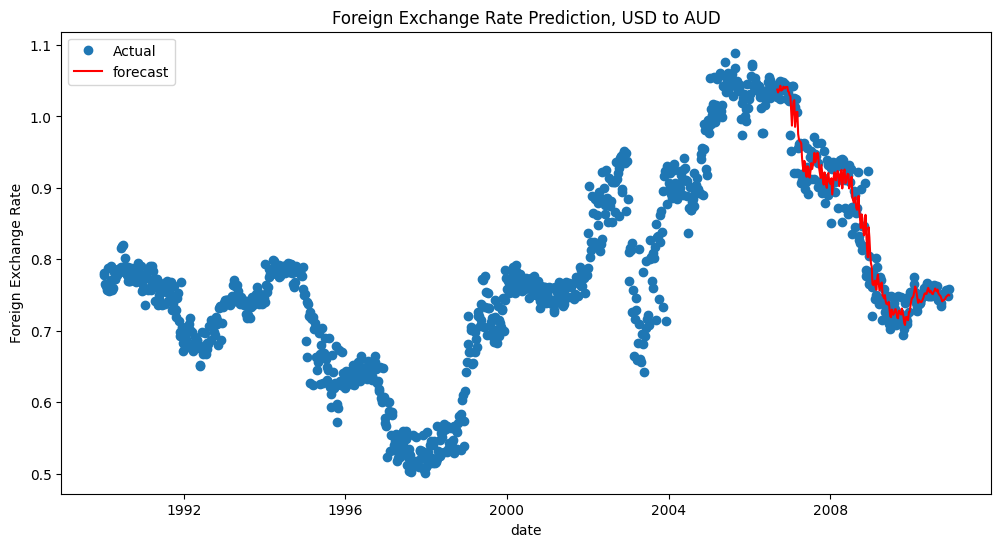

In [50]:
#Plotting the graph with predicted data and resampled weekly data index since the prediction is based on test data.

plt.rcParams['figure.figsize'] = (12,6)
fig, ax = plt.subplots()
ax.set(title='Foreign Exchange Rate Prediction, USD to AUD', xlabel='date', ylabel='Foreign Exchange Rate')
ax.plot(data_week, 'o', label='Actual')
ax.plot(predictions_df, 'r', label='forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
plt.savefig('Foreign Exchange Rate Prediction - USD to AUD.png')

## Completed